# Linear Regression

# Volusia County Price Analysis

In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras
import pyproj
import folium
import folium.features as ftr
import shapely
import shapely.wkt
import shapely.ops as ops
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Connecting to our AWS database and running a query

In [2]:
conn = psycopg2.connect("dbname='spatial' user='postgres' host='volusia-gis.c21rgtvxg36z.us-east-2.rds.amazonaws.com' password='administrator'")

cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

# Houses with 32114 or 32118 ZIP code, single family only, at most 2 years since the sale, price between 50k and 750k
sql1 = "select parid, luc, luc_desc, aprbldg, aprland, aprtot, nbhd, sale_date, price, zip1, rmbed, sfla, total_area, yrblt, misc_area, months_since_sale, ST_AsText(geom) as wkt, water_front, has_pool from volusia.sales_analysis" \
       " where (zip1 ilike '32114' or zip1 ilike '32118')" \
       " and luc_desc ilike 'Single Family'" \
       " and months_since_sale <= 24" \
       " and price > 50000 and price < 750000" 
df = pd.read_sql_query(sql1, conn)

The query pulls in the parcel id, land use code (LUC), LUC description, appraisal for buildings, appraisal for land, appraisal for total, sale date, price, zipcode, total_area, year built, misc area, months since last sold, geomotry, is waterfront, and has pool. The data is only reflective of single family homes which were sold at most 2 years ago, with a price between 50,000 and 750,000.

In [3]:
df.head()

,parid,luc,luc_desc,aprbldg,aprland,aprtot,nbhd,sale_date,price,zip1,rmbed,sfla,total_area,yrblt,misc_area,months_since_sale,wkt,water_front,has_pool
0,3535715.0,0100,Single Family,162334.0,23040.0,185374.0,3421,2019-07-26,225000.0,32114,2.0,1398.0,2345.0,1970.0,1001.0,19,"MULTIPOLYGON(((650128.487 1762133.073,650024.5...",0,1
1,3099851.0,0100,Single Family,124865.0,56228.0,181093.0,2262,2020-05-12,190000.0,32118,3.0,1914.0,3257.0,1953.0,330.0,9,"MULTIPOLYGON(((647246.227000002 1790190.949,64...",0,1
2,3136756.0,0100,Single Family,168066.0,71253.0,239319.0,2252,2020-12-15,320000.0,32118,4.0,2020.0,2686.0,1956.0,143.0,2,"MULTIPOLYGON(((649543.328249998 1785400.267,64...",0,1
3,3534913.0,0100,Single Family,138357.0,22800.0,161157.0,3417,2020-01-22,185000.0,32114,3.0,1629.0,2439.0,1973.0,180.0,13,"MULTIPOLYGON(((648577.965 1763498.006,648477.9...",0,1
4,3538510.0,0100,Single Family,117081.0,16380.0,133461.0,3817,2019-11-22,160000.0,32114,2.0,989.0,1736.0,1963.0,100.0,15,"MULTIPOLYGON(((645547.147999998 1762439.891,64...",0,1


## Visualization of Dataset

In [4]:
parcel_map = folium.Map(location=[29.1887876219045, -81.0494807582431], zoom_start=10, width="100%")

def highlight_function(feature):  
    return
    {
        'weight': 3,
        'color': '#FF0000',
        'dashArray': '',
        'fillOpacity': 0.5
    };

def style_function(feature): 
    return
    {
        'weight': 1.5,
        #'color': 'blue',
        'dashArray': '5, 5',
        'fillOpacity': 0.7
    };

parcel_layer = folium.FeatureGroup(name="parcels")
label_layer = folium.FeatureGroup(name="price_labels")

zillowParids = [4811435, 5056015, 3403851, 3247922, 3568486]

for index, row in df.iterrows():    

    if (row.parid not in zillowParids):
        continue

    tooltip_show = 'Price: ' + str(int(row.price))
    geom = shapely.wkt.loads(row.wkt)
    wgs_geom = ops.transform(pyproj.Transformer.from_crs(pyproj.CRS('EPSG:2236'), pyproj.CRS('EPSG:4326'), always_xy=True) .transform, geom)
    
    parcel_json= folium.GeoJson(shapely.geometry.asShape(wgs_geom),
                       name='parcels',
                       overlay=True,
                       #style_function=style_function,
                       #highlight_function=highlight_function,
                       tooltip=tooltip_show 
    )
    
    popup_string = '<table>'

    for i, v in row.iteritems():
        popup_string += "<tr><td>%10s</td><td>&nbsp;" % i.title() + " " + str(v) + "</td></tr>\n"

    popup_string += "</table>"
    folium.Popup(popup_string).add_to(parcel_json)
    
    parcel_layer.add_child(parcel_json)
    
    divlabel = '<div style="font-size: 14pt; color : black">' + tooltip_show + '</div>'
    marker = folium.Marker(
        [wgs_geom.centroid.y, wgs_geom.centroid.x], 
        icon=ftr.DivIcon(html=divlabel)
    ).add_to(label_layer)

parcel_layer.add_to(parcel_map)
label_layer.add_to(parcel_map)

parcel_map.add_child(folium.LayerControl(position='topright', collapsed=False))

parcel_map.fit_bounds(parcel_layer.get_bounds())

parcel_map

# Data Cleansing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 19 columns):
parid                781 non-null float64
luc                  781 non-null object
luc_desc             781 non-null object
aprbldg              781 non-null float64
aprland              781 non-null float64
aprtot               781 non-null float64
nbhd                 781 non-null object
sale_date            781 non-null object
price                781 non-null float64
zip1                 781 non-null object
rmbed                781 non-null float64
sfla                 781 non-null float64
total_area           781 non-null float64
yrblt                781 non-null float64
misc_area            781 non-null float64
months_since_sale    781 non-null int64
wkt                  781 non-null object
water_front          781 non-null int64
has_pool             781 non-null int64
dtypes: float64(10), int64(3), object(6)
memory usage: 116.1+ KB


This is to gain a better understanding of the shape of the data before we started working on the featuers for the machine learning section of this project and to make sure we do not need to clean any null values or other anomolies

# Feature Selection

First we find the features in the data set which most highly correlate to the price to focus on. This helps us build a baseline model for testing addition of more features down the line.

In [6]:
corr = df.corr()
print('TOP 4 FEATURES:', df.corr().abs().nlargest(6, 'price').index)

# My first query was for any house in Volusia, limit 5k
# The two top features then were aprland and aprtot
# So, it seems that for ZIP codes 32114 and 32118, aprbldg is more significant than aprland

TOP 4 FEATURES: Index(['price', 'aprtot', 'aprbldg', 'aprland', 'total_area', 'sfla'], dtype='object')


Next is to investigate these correlations to how they relate to price specifically, the best way for us is to visualize them on a plot

Text(0, 0.5, 'price')

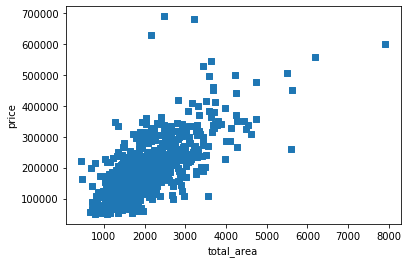

In [7]:
plt.scatter(df['total_area'], df['price'], marker='s')
plt.xlabel('total_area')
plt.ylabel('price')

# aprbldg correlates heavily with price

From this visualization we can tell there is a positive linear correlation between the total area of the property vs the price. However, at a ceratin point there seems to be much less corrilation beyond that point. Somewhere around 3,500 and 400,000 price something happens which greatly effects the correlation between the two 

Text(0, 0.5, 'price')

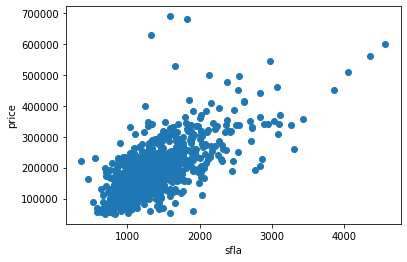

In [8]:
get_ipython().run_line_magic('matplotlib', 'inline')

plt.scatter(df['sfla'], df['price'], marker='o')
plt.xlabel('sfla')
plt.ylabel('price')

# aprtot correlates heavily with price

We preformed the same visualization on the square footage of living area vs price columns and we can see there is a positive correlation there with some outlyers found above 400,000 in price.

# Training the Model (total_area, sfla -> price)

### Default, top two features, no additions

We're now creating a data set with the total area and square footage of living area to run a linear regression upon. Then compare it with the known values of the test set to see if the correlation is strong enough to develop a predictive model.

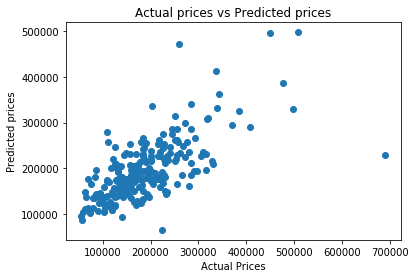

In [9]:
x = pd.DataFrame(np.c_[df['total_area'], df['sfla']], columns = ['total_area','sfla'])
Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

In [10]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 3954518133.4446
R-squared: 0.4563
Intercept: 25469.8187
Coefficients:  [55.11346697 41.70729175]


With an R-squared of 0.4926, the values we testing did not come up with a strong correlation between the values after the training, which we already discovered, and a MSE of 3751069325 our model isn't good and isn't reliable 

# Comparing 5 Zillow Prices (total_area, sfla -> price)

In [11]:
def getZillowError(dataframe, ml, columns):
    zillowDetails1 = dataframe.loc[dataframe['parid'] == 4811435]

    zillowDetails2 = dataframe.loc[dataframe['parid'] == 5056015]

    zillowDetails3 = dataframe.loc[dataframe['parid'] == 3403851]

    zillowDetails4 = dataframe.loc[dataframe['parid'] == 3247922]

    zillowDetails5 = dataframe.loc[dataframe['parid'] == 3568486]

    zillowRows =    [zillowDetails1,    zillowDetails2,     zillowDetails3,     zillowDetails4,     zillowDetails5]
    zillowPrices =  [169900,            450000,             299000,             390628,             566822]

    print("DIFFERENCES FROM ZILLOW PRICES")
    # multi family parid=3521706 or parid=3524047

    for i in range(len(zillowRows)):
        print("For parid {0}: ".format(zillowRows[i]['parid'].item()), round(float(abs(((ml.predict(zillowRows[i][columns])) - zillowPrices[i]))/zillowPrices[i] * 100), 2), '%')

getZillowError(df, model, ['total_area', 'sfla'])

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  50.99 %
For parid 5056015.0:  62.04 %
For parid 3403851.0:  57.88 %
For parid 3247922.0:  6.89 %
For parid 3568486.0:  12.09 %


As you can see here the average percentage error is 38.56%  with a median of 51.24% so it's not a good predictive model in the least. Lets see if we can add more feature to the modle and come up with a better model based on that

# Training the Model (total_area, sfla, elev -> price)

### Added Procko's Parcel Elevation Numbers

The next feature we're going to be examining is the elevation of the homes. The thought being the closer to water level the more likely the home is waterfront, or other correlation such as that

In [12]:
sql1 = "select s.parid as parid, s.price, s.sfla, s.total_area, ca.elev from volusia.sales_analysis s, volusia.contours_analysis2 ca" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

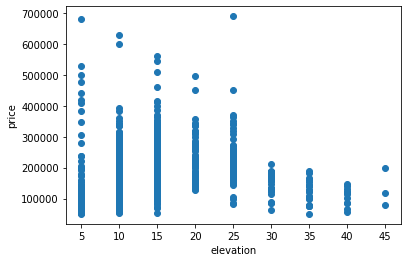

In [13]:
corr = df.corr()

plt.scatter(df['elev'], df['price'], marker='o')
plt.xlabel('elevation')
plt.ylabel('price')

# Elevation does seem to correlate with prices, in this fashion:
# Higher elevations correlate with lower prices
# Lower elevations correlate with higher prices
# This makes sense, since the ZIP codes used were for Daytona Beach, which is mostly beachfront/close to beach houses
# Therefore, it is assumed that people pay a premium for beach life, at the expense of lower elevation

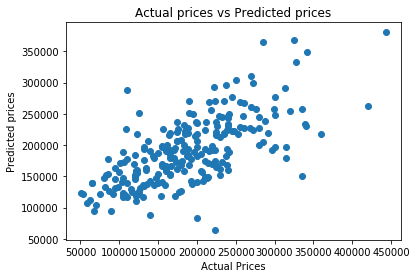

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  47.05 %
For parid 5056015.0:  64.44 %
For parid 3403851.0:  57.52 %
For parid 3247922.0:  10.17 %
For parid 3568486.0:  13.27 %


In [14]:
clmns = ['total_area','sfla','elev']

x = pd.DataFrame(np.c_[df['total_area'], df['sfla'], df['elev']], columns = clmns)
Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [15]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 2721155666.4553
R-squared: 0.4511
Intercept: 35247.9055
Coefficients:  [  58.98932543   34.70707641 -625.73345171]


Interestingly this feature improved the percentage error for some of the zillow parcels, but made it worse for others. The resultant average was 38.49% error with a median of 47.05%. The addition of this feature actually decreased the average and median errors. However, it decreased the r-squared value by around 4% and decreased the MSE substantially. This results in a positive change to the model making it noticable more accurate across the data set

# Training the Model (total_area, sfla, elev, groc -> price)

Our next step was adding another feature to the data set again, this being the distance to the nearest grocery store

### Added Fawzia's Grocery Distance Numbers

In [16]:
sql1 = "select s.parid as parid, s.price, s.total_area, s.sfla, ca.elev, gd.groc_distance from volusia.sales_analysis s, volusia.contours_analysis2 ca, volusia.groceries_distance gd" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid and s.parid = gd.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

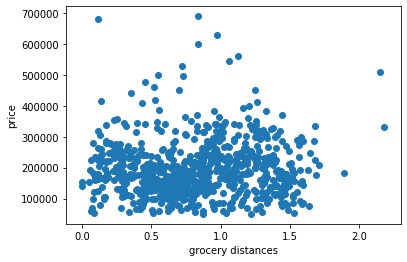

In [17]:
corr = df.corr()

plt.scatter(df['groc_distance'], df['price'], marker='o')
plt.xlabel('grocery distances')
plt.ylabel('price')

# No observable correlation with grocery distances

This feature does not seem to have any real correlation with the price of the house as there seems to be an even spread for most of the range the data covers, but we will add it to our model anyway to see if ti improves anything however we predicted that it should cause no major changes in the model beyond lowering it's r-squared value

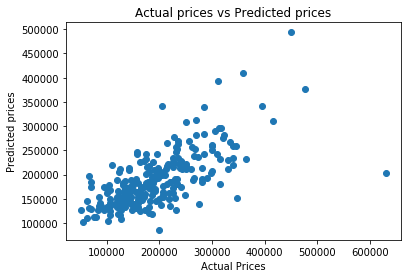

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  42.81 %
For parid 5056015.0:  66.42 %
For parid 3403851.0:  50.1 %
For parid 3247922.0:  11.56 %
For parid 3568486.0:  8.28 %


In [18]:
clmns = ['total_area','sfla','elev','groc_distance']

x = pd.DataFrame(np.c_[df['total_area'], df['sfla'], df['elev'], df['groc_distance']], columns = clmns)
Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [19]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 3635945358.4384
R-squared: 0.4620
Intercept: 19524.1930
Coefficients:  [   50.62065866    46.98228713  -825.99239497 20063.75886975]


The introduction of this data field into our model casued average percent error to become 35.9% which is the rather sizable decrease from the previous average. The median also decreased to a value of 43.64%. Despite predictions even the r-squared value increased slightly from the previous model

# Training the Model (total_area, sfla, elev, groc, schools -> price)

The next attribute added will be distance to nearest elementary, middle, and high school and how it effects price

### Added Tim Elvira's School Distance Numbers

In [20]:
sql1 = "select s.parid as parid, s.price, s.total_area, s.sfla, ca.elev, gd.groc_distance, sz.distance_to_elem_school, sz.distance_to_middle_school, sz.distance_to_high_school, sz.nearest_elem_school, sz.nearest_middle_school, sz.nearest_high_school from volusia.sales_analysis s, volusia.contours_analysis2 ca, volusia.groceries_distance gd," \
       " volusia.schoolzones sz" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid and s.parid = gd.parid and s.parid = sz.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

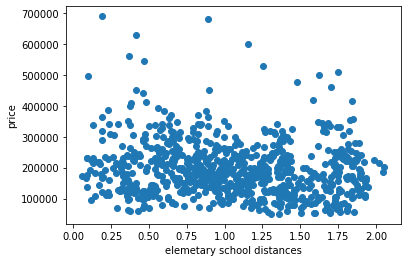

In [21]:
corr = df.corr()

plt.scatter(df['distance_to_elem_school'], df['price'], marker='o')
plt.xlabel('elemetary school distances')
plt.ylabel('price')

# No observable correlation with elementary school distances

Text(0, 0.5, 'price')

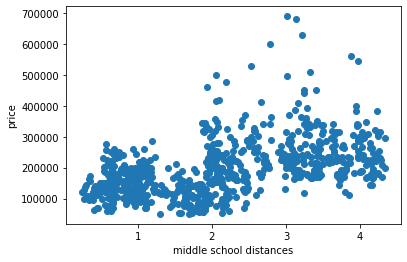

In [22]:
plt.scatter(df['distance_to_middle_school'], df['price'], marker='o')
plt.xlabel('middle school distances')
plt.ylabel('price')

# Possible, very loose correlation with middle school distances

Text(0, 0.5, 'price')

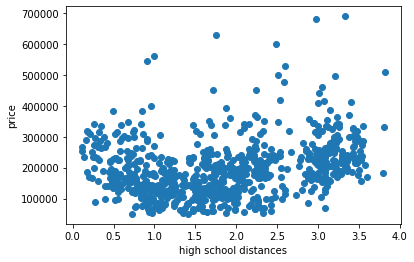

In [23]:
plt.scatter(df['distance_to_high_school'], df['price'], marker='o')
plt.xlabel('high school distances')
plt.ylabel('price')

# No observable correlation with high school distances

Text(0, 0.5, 'price')

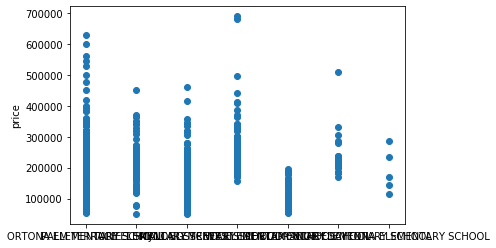

In [24]:
plt.scatter(df['nearest_elem_school'], df['price'], marker='o')
plt.xlabel('')
plt.ylabel('price')
# Possible indication that the second and last elementary schools being nearest may indicate lower property value

Text(0, 0.5, 'price')

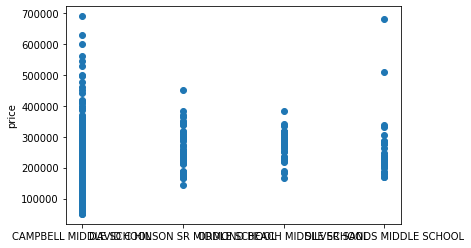

In [25]:
plt.scatter(df['nearest_middle_school'], df['price'], marker='o')
plt.xlabel('')
plt.ylabel('price')

# No observable correlation with nearest middle schools

Text(0, 0.5, 'price')

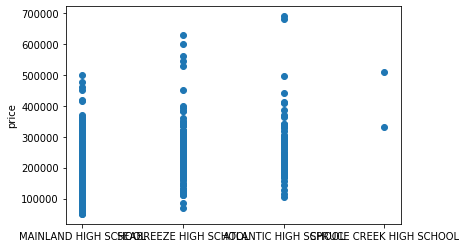

In [26]:
plt.scatter(df['nearest_high_school'], df['price'], marker='o')
plt.xlabel('')
plt.ylabel('price')

# No observable correlation with nearest high schools

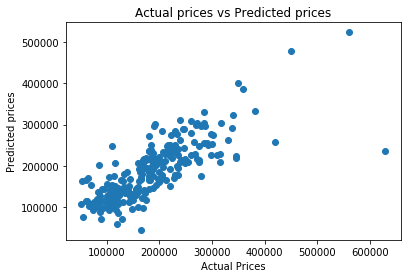

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  60.41 %
For parid 5056015.0:  63.18 %
For parid 3403851.0:  41.75 %
For parid 3247922.0:  8.32 %
For parid 3568486.0:  10.55 %


In [27]:
# No great correlation with nearest school names, so we're going to leave that out of the model
# Also we can't put them in the model because they aren't numerical... we'd have to normalize them to numbers

clmns = ['total_area', 'sfla', 'elev', 'groc_distance', 'distance_to_elem_school', 'distance_to_middle_school', 'distance_to_high_school']

x = pd.DataFrame(
    np.c_[df['total_area'], df['sfla'], 
          df['elev'], 
          df['groc_distance'], 
          df['distance_to_elem_school'], df['distance_to_middle_school'], df['distance_to_high_school']],
    columns = clmns)
Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [28]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 2691610718.6990
R-squared: 0.6070
Intercept: -2349.6878
Coefficients:  [    42.19379108     40.04045198  -1084.02810324   3973.99649525
 -19342.17814043  22851.72644368  20974.42113373]


The addition of distances from schools greately improved the R-squared values of the model a drastic amount. While the correlation was much stronger the results of the zillow comparison has an average of 36.9% which is quite a bit higher, 1%, than the previous average and median of 42.41% which is slightly lower than the previous. This model is now more strong correlated, but less accurate.

# Training the Model (total_area, sfla, elev, groc, schools, flood -> price)

Yet another attribute we're checking is the distance to a flood zone

### Added Kevin Dumitrescu's Flood Zone Distance Numbers

In [29]:
sql1 = "select s.parid as parid, s.price, s.total_area, s.sfla, ca.elev, gd.groc_distance, sz.distance_to_elem_school, sz.distance_to_middle_school, sz.distance_to_high_school, sz.nearest_elem_school, sz.nearest_middle_school, sz.nearest_high_school, fz.fzdistance from volusia.sales_analysis s, volusia.contours_analysis2 ca, volusia.groceries_distance gd," \
       " volusia.schoolzones sz, volusia.floodzones fz" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid and s.parid = gd.parid and s.parid = sz.parid and s.parid=fz.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

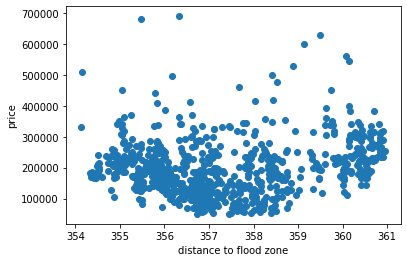

In [30]:
corr = df.corr()

plt.scatter(df['fzdistance'], df['price'], marker='o')
plt.xlabel('distance to flood zone')
plt.ylabel('price')

# No observable correlation with flood zone distance

There is no super obvious corrlation here as it seems there is a fairly random spread but we're adding it to the model.

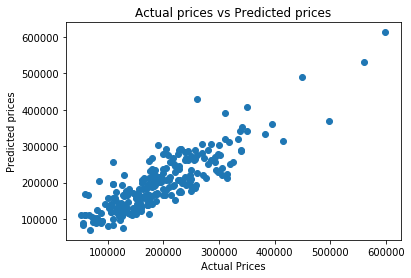

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  57.21 %
For parid 5056015.0:  63.1 %
For parid 3403851.0:  44.11 %
For parid 3247922.0:  10.32 %
For parid 3568486.0:  11.14 %


In [31]:
clmns = ['total_area', 'sfla', 'elev', 'groc_distance', 'distance_to_elem_school', 'distance_to_middle_school', 'distance_to_high_school', 'fzdistance']

x = pd.DataFrame(
    np.c_[df['total_area'], df['sfla'], 
          df['elev'], 
          df['groc_distance'], 
          df['distance_to_elem_school'], df['distance_to_middle_school'], df['distance_to_high_school'],
          df['fzdistance']],
    columns = clmns)

Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [32]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 1953272120.0180
R-squared: 0.7330
Intercept: -1219700.5938
Coefficients:  [    45.36019088     36.65117582   -710.40808082   8012.57003951
 -22366.83524809  19118.5783544   23770.59840344   3396.94512339]


This one brought the average error for the zillow prices up to 37.17% and a median of 44.14% with the R-squared of 0.6146. This hasn't made any major change to the model at this point. For now it seems that adding more features does not greatly effect or change this model since there are so many in this model already.

# Training the Model (total_area, sfla, elev, groc, schools, flood, railroads -> price)

### Tim Bernard's Railroad Track Distance Numbers

In [33]:
sql1 = "select s.parid as parid, s.price, s.total_area, s.sfla, ca.elev, gd.groc_distance, sz.distance_to_elem_school, sz.distance_to_middle_school, sz.distance_to_high_school, sz.nearest_elem_school, sz.nearest_middle_school, sz.nearest_high_school, fz.fzdistance, rr.rrdistance from volusia.sales_analysis s, volusia.contours_analysis2 ca, volusia.groceries_distance gd," \
       " volusia.schoolzones sz, volusia.floodzones fz, volusia.railroads rr" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid and s.parid = gd.parid and s.parid = sz.parid and s.parid=fz.parid and s.parid=rr.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

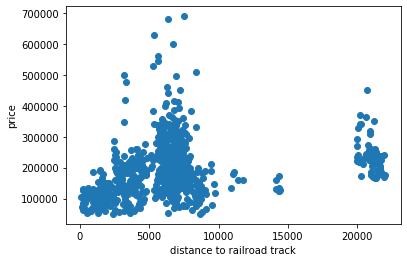

In [34]:
corr = df.corr()

plt.scatter(df['rrdistance'], df['price'], marker='o')
plt.xlabel('distance to railroad track')
plt.ylabel('price')

# No observable correlation with distance to railroad tracks...
# But the correlation graph below is very interesting
# It seems that the last group (~20000+ distance to a railroad track) has a lower limit well above the other lower limits
# Perhaps houses cost a bit more so you do not hear the trains

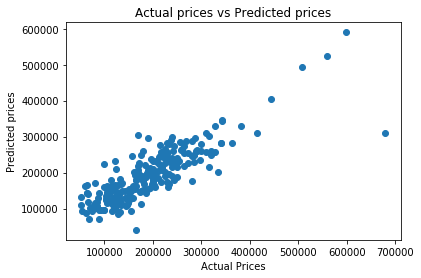

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  52.26 %
For parid 5056015.0:  62.91 %
For parid 3403851.0:  40.95 %
For parid 3247922.0:  11.6 %
For parid 3568486.0:  13.0 %


In [35]:
clmns = ['total_area', 'sfla', 'elev', 'groc_distance', 'distance_to_elem_school', 'distance_to_middle_school', 'distance_to_high_school', 'fzdistance', 'rrdistance']

x = pd.DataFrame(
    np.c_[df['total_area'], df['sfla'], 
          df['elev'], 
          df['groc_distance'], 
          df['distance_to_elem_school'], df['distance_to_middle_school'], df['distance_to_high_school'],
          df['fzdistance'],
          df['rrdistance']],
    columns = clmns)

Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [36]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 2421457556.5913
R-squared: 0.7144
Intercept: -208443.8487
Coefficients:  [ 4.16531278e+01  3.86934446e+01 -2.84691482e+02  4.08400380e+02
 -1.72453576e+04  2.52228464e+04  1.93474489e+04  5.71961769e+02
 -1.38458736e+00]


The new average is 35.17% so surprisingly this feature increased the accuracy of our model by a few percentage points. The new median is 43.11% so it really did improve the overall accuracy of the model a good bit

# Training the Model (total_area, sfla, elev, groc, schools, flood, railroads, boatramps -> price)

### Kody Miller's Boatramp/Marina Distance Numbers

In [37]:
sql1 = "select s.parid as parid, s.price, s.total_area, s.sfla, ca.elev, gd.groc_distance, sz.distance_to_elem_school, sz.distance_to_middle_school, sz.distance_to_high_school, sz.nearest_elem_school, sz.nearest_middle_school, sz.nearest_high_school, fz.fzdistance, rr.rrdistance, br.br_distance, br.mar_distance from volusia.sales_analysis s, volusia.contours_analysis2 ca, volusia.groceries_distance gd," \
       " volusia.schoolzones sz, volusia.floodzones fz, volusia.railroads rr, volusia.boatramps br" \
       " where (s.zip1 ilike '32114' or s.zip1 ilike '32118')" \
       " and s.luc_desc ilike 'Single Family'" \
       " and s.months_since_sale <= 24" \
       " and s.price > 50000 and s.price < 750000" \
       " and s.parid = ca.parid and s.parid = gd.parid and s.parid = sz.parid and s.parid=fz.parid" \
       " and s.parid=rr.parid and s.parid=br.parid"
df = pd.read_sql_query(sql1, conn)

Text(0, 0.5, 'price')

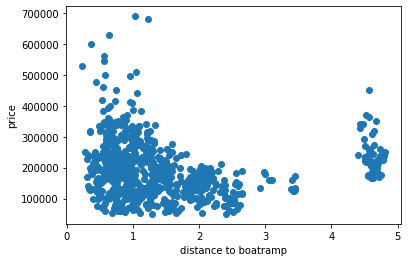

In [38]:
corr = df.corr()

plt.scatter(df['br_distance'], df['price'], marker='o')
plt.xlabel('distance to boatramp')
plt.ylabel('price')

# More of an outlier situation with this feature
# The cluster on the tail end is interesting, but I cannot speculate as to why it's there
# But it can be seen that, somewhat, prices increase the closer boatramps are

Text(0, 0.5, 'price')

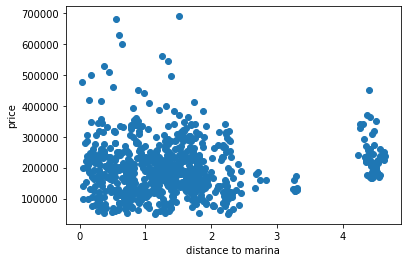

In [39]:
corr = df.corr()

plt.scatter(df['mar_distance'], df['price'], marker='o')
plt.xlabel('distance to marina')
plt.ylabel('price')

# Same situation as the boatramp feature, see above

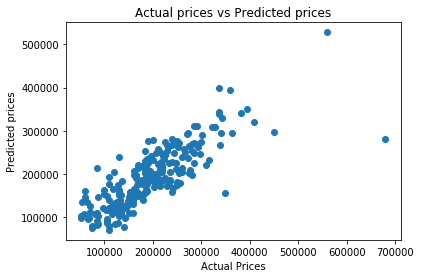

DIFFERENCES FROM ZILLOW PRICES
For parid 4811435.0:  38.47 %
For parid 5056015.0:  65.98 %
For parid 3403851.0:  41.87 %
For parid 3247922.0:  15.61 %
For parid 3568486.0:  12.97 %


In [40]:
clmns = ['total_area', 'sfla', 'elev', 'groc_distance', 'distance_to_elem_school', 'distance_to_middle_school', 'distance_to_high_school', 'fzdistance', 'rrdistance', 'br_distance', 'mar_distance']

x = pd.DataFrame(
    np.c_[df['total_area'], df['sfla'], 
          df['elev'], 
          df['groc_distance'], 
          df['distance_to_elem_school'], df['distance_to_middle_school'], df['distance_to_high_school'],
          df['fzdistance'],
          df['rrdistance'],
          df['br_distance'], df['mar_distance']],
    columns = clmns)

Y = df['price']
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state=5)

model = LinearRegression()
model.fit(x_train, Y_train)
price_pred = model.predict(x_test)
plt.scatter(Y_test, price_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.title("Actual prices vs Predicted prices")
plt.show()

getZillowError(df, model, clmns)

In [41]:
mse = mean_squared_error(Y_test, price_pred)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % model.score(x_test, Y_test))
print('Intercept: %.4f'% model.intercept_)
print('Coefficients: ', model.coef_)

MSE: 2402007940.5024
R-squared: 0.6683
Intercept: 2596714.5321
Coefficients:  [ 3.56838680e+01  4.48730054e+01 -2.69393938e+02 -3.71182514e+02
 -7.50648393e+03  1.24472923e+04  2.80104698e+03 -7.12351622e+03
  8.35743518e+00 -6.95761757e+04  2.19446434e+04]


The final model we came up with had an average error of 35.66% for the zillow prices with a median value of 44.83% which leaves us with an accuracy of 64.34% which is not a reliable algorithm. I believe this is due to the complex nature of the topic we're covering with a very simple algorigth

# Conclusions

## The topic is highly complex

Through this project we have discovered how complex the correlations between different aspects of things like houses effect and weight in on the perceived value of the item. Then using a simple algorithm like linear regression to try to predict the trends accurately just doesn't work. 

Another lesson we learned has to do wiht how much actually goes into projects of this size. The amount of time that is put into isolating, calculating, cleaning, and aggregating data attributes into usable formats is staggering. The longest part of this project was our individual sections where we preformed tasks upon the data to gather features for examination. The rest of the project was fairly trivial in complexity compared to the indiviual research topics.

Another thing we learned about linear regression specifically was that just becasue an attribute does not directly seem correlated to the subject of examination does not mean it for certain won't improve an algorithm, but whether that is the rule or the exception is yet to be seen.

## Next steps

If we were to work on this more into the future, the biggest thing we would focus upon is the ML algorithm used. Linear regression is a powerful but somewhat simplistic algorith for something that takes this number of attributes. I would like to attempt it using an algorithm like random forest or even a decision tree. There is just so much connecting all the attributes together and they're so interdependent something like linear regression just isn't designed to handle it. In all reality a decision tree might even be too simplistic, but we think it's a step in the right direction as it can take the dependent attributes into account. For example if a property has low elevation and is waterfront, it could then idenify that is much more desirable than low elevation not near water. 

Beyond that, perhaps doing a deep dive into the shape and structure of the houses where we examine what makes a mediocre house mediocre, an expensive one expensive, and a cheap one cheap. Idenify patterns off of those cases and expand from there rather than pick arbitrary attributes to explore. 

In conclusion, this project served as a great learning tool to bring together much of what the course discussed and provided a source of interesting exploration for us while working on it. It sparked an interest in the field for quite a few students in the course, our team included. Despite setbacks and what can best be called a mediocre 

---
# Sales Analysis Table

In [42]:
pd.set_option('display.max_colwidth', None)

zillowParcels = df[df['parid'].isin(zillowParids)]

zillowParcels['parid_link'] = zillowParcels.apply(lambda row: 'https://vcpa.vcgov.org/parcel/summary/?altkey=' + str(int(row.parid)) + '#gsc.tab=0', axis=1)

zillowParcels['parid_map'] = zillowParcels.apply(lambda row: 'https://vcpa.vcgov.org/parcel/map/?altkey=' + str(int(row.parid)) + '#gsc.tab=0', axis=1)

zillowParcels

ValueError: Value must have type '<class 'int'>'